# Exploring simulations result

### This notebook is for exploratory analysis of the simulation results. It expects two files 
- variable named as "network_json_file" for network results file 
- variable named "json_file" for simulaton results

While network structure remains same, there is difference in values of alpha in each simulation files which were generated with random seeds.

In [1]:
import json
import pandas as pd
import numpy as np

import utilities
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
%matplotlib inline

In [3]:
sns.set(style='whitegrid', rc={'figure.figsize':(11, 8)}) # setting seaborn style

The network was created using networkx and "newman_watts_strogatz_graph" with following parameters:
- number of nodes = num_agents (i.e. 100) 
- \# of neighbors in ring topology = 10
- probabiity of adding new edge = 0.5

For more details refer to __[Networkx Documentation](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.newman_watts_strogatz_graph.html)__

Below is the code for displaying the network structure. Not specific to current analysis may be different network structures and parameters values can result in different results which may need further analysis.

C:\Users\niraj\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


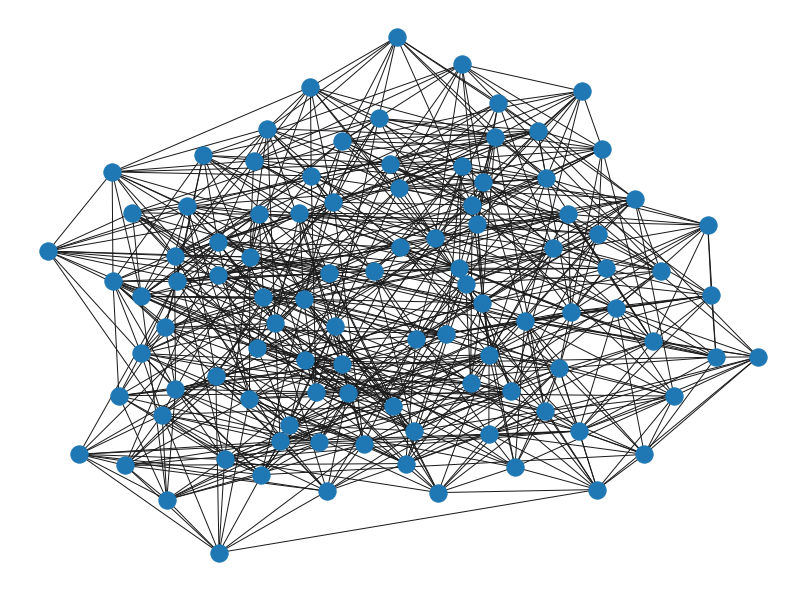

In [4]:
network_json_file = "simulations\\test_network.json"
network_data = []
network_df = pd.read_json(network_json_file, orient='records', lines=True)
network_df.head()
network_dict = {i['Agent Name']:i['Neighbors'] for i in network_df.to_dict('records')}
# network_dict
graph = nx.from_dict_of_lists(network_dict)
nx.draw_spring(graph)

Below is the analysis of the single json simulation file.

In [5]:
json_file = "simulations\\test_result_7.json"
tmp_df = utilities.read_json_to_df(json_file)
raw_df = tmp_df.copy()

tmp_df['Current_Knowledge_State'] = tmp_df['Current_Knowledge_State'].apply(lambda row: utilities.bool2int(row))
tmp_df['Next_Knowledge_State'] = tmp_df['Next_Knowledge_State'].apply(lambda row: utilities.bool2int(row))

In [6]:
# pd.set_option('display.max_rows', 1100)
# pd.set_option('display.max_columns', 1100)
# pd.set_option('display.width', 1100)

In [7]:
def plot_heatmap(org_df, alpha_val=None):
    if alpha_val:
        sel_df = org_df[org_df['alpha']==alpha_val]
    else:
        sel_df = org_df.copy()
    all_states = set([i for i in range(1024)])


    sim_current_states = set(sel_df['Current_Knowledge_State'].to_list())
    sim_next_states = set(sel_df['Next_Knowledge_State'].to_list())

    missing_states1 = list(all_states-sim_current_states)
    missing_states2 = list(all_states-sim_next_states)

    states_df = sel_df.groupby(['Current_Knowledge_State', 'Next_Knowledge_State']).size().to_frame('Count')

    states_df.reset_index(inplace=True)

    missing_df = pd.DataFrame({'Current_Knowledge_State': missing_states1, 'Next_Knowledge_State': np.nan})
    states_df = pd.concat([states_df, missing_df], sort=False)
    sorted_df = states_df.sort_values('Count', ascending=False)
    print('Top 10 highest frequent state transitions are: ')
    display(sorted_df.head(10))

    missing_df2 = pd.DataFrame({'Current_Knowledge_State': np.nan, 'Next_Knowledge_State': missing_states2})
    states_df = pd.concat([states_df, missing_df2], sort=False)
    states_df['Count'] = states_df['Count'].fillna(0)
    table = states_df.pivot(index='Current_Knowledge_State', columns='Next_Knowledge_State', values='Count')
    table.fillna(0, inplace=True)
    table.drop(np.nan, axis=0, inplace=True, errors='ignore')
    table.drop(np.nan, axis=1, inplace=True, errors='ignore')

    normalized_df=table.div(table.sum(axis=1), axis=0)
    normalized_df.fillna(0, inplace=True)

    fig, ax = plt.subplots(1,2)
    sns.heatmap(normalized_df, xticklabels=50, yticklabels=50, vmin=0, vmax=1, ax=ax[0], cbar_kws={"orientation": "horizontal"}, cmap="Reds_r");
    plt.spy(table, markersize=1);

In [8]:
def plot_bit_changes(dataframe, alpha_val=None):
    print('Bit Changes for Alpha value {}'.format(alpha_val))
    
    if alpha_val:
        df = dataframe[dataframe['alpha']==alpha_val]
    else:
        df = dataframe.copy()

    df = df[['Current_Knowledge_State', 'Time']]

    for i in range(10):
        df['bit{0}'.format(i)] = df['Current_Knowledge_State'].apply(lambda row: row[i]==1)

    bits_col = ['bit{}'.format(i) for i in range(10)]
    z = df[['Time']+bits_col].melt(id_vars=['Time'])
    z['value'].replace({False:'0', True:'1'}, inplace=True)
    z = z.groupby(['Time','variable','value']).size().to_frame('# of Agents').reset_index()
    
    sns.catplot(data=z, x='Time', y='# of Agents', hue='value', col='variable', col_wrap=1, kind='point', height=5, aspect=4.5)
    plt.xticks(rotation=90);

When alpha value was 0, it was found that from any knowledge state, it could jump to different knowledge state which shows some sort of randomness. However there is still some degree of control on jump that is mostly as heatmap which is normalized based on probabiltiy shows concerntration on diagonal line. Also looking at the bits change with time, we can see that as time increases the gap in number of agents reduces which was initially large.

Top 10 highest frequent state transitions are: 


,Current_Knowledge_State,Next_Knowledge_State,Count
2041,403,403.0,23.0
2043,403,411.0,21.0
2205,435,434.0,16.0
3886,743,741.0,15.0
733,163,179.0,13.0
3469,664,664.0,12.0
2035,403,275.0,11.0
3619,692,692.0,11.0
2593,504,506.0,11.0
2181,433,435.0,11.0


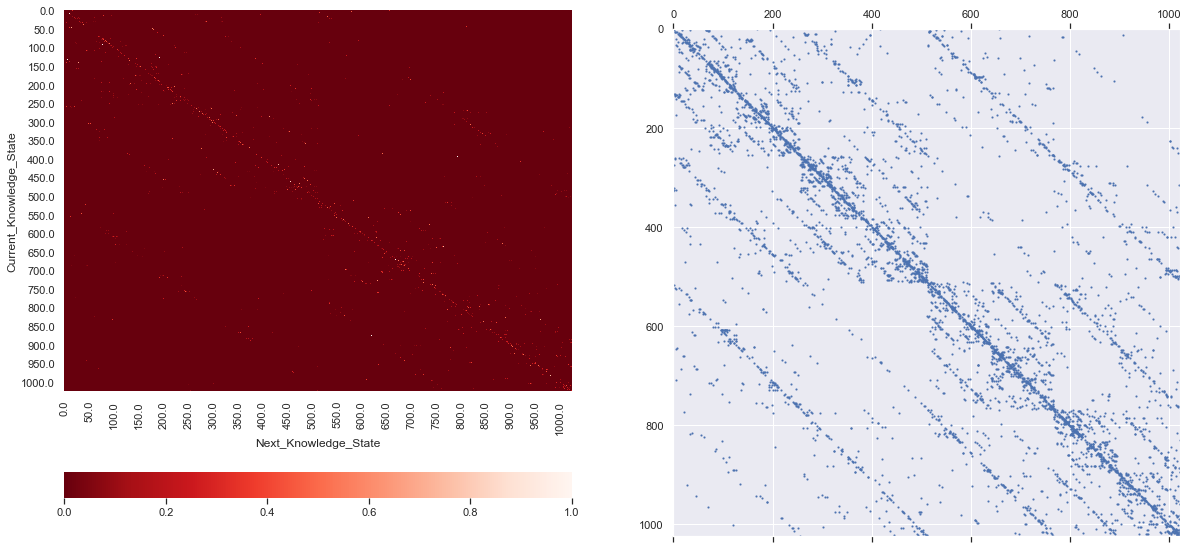

In [9]:
sns.set(rc={'figure.figsize':(20,10)})
plot_heatmap(tmp_df, '0')

Bit Changes for Alpha value 0


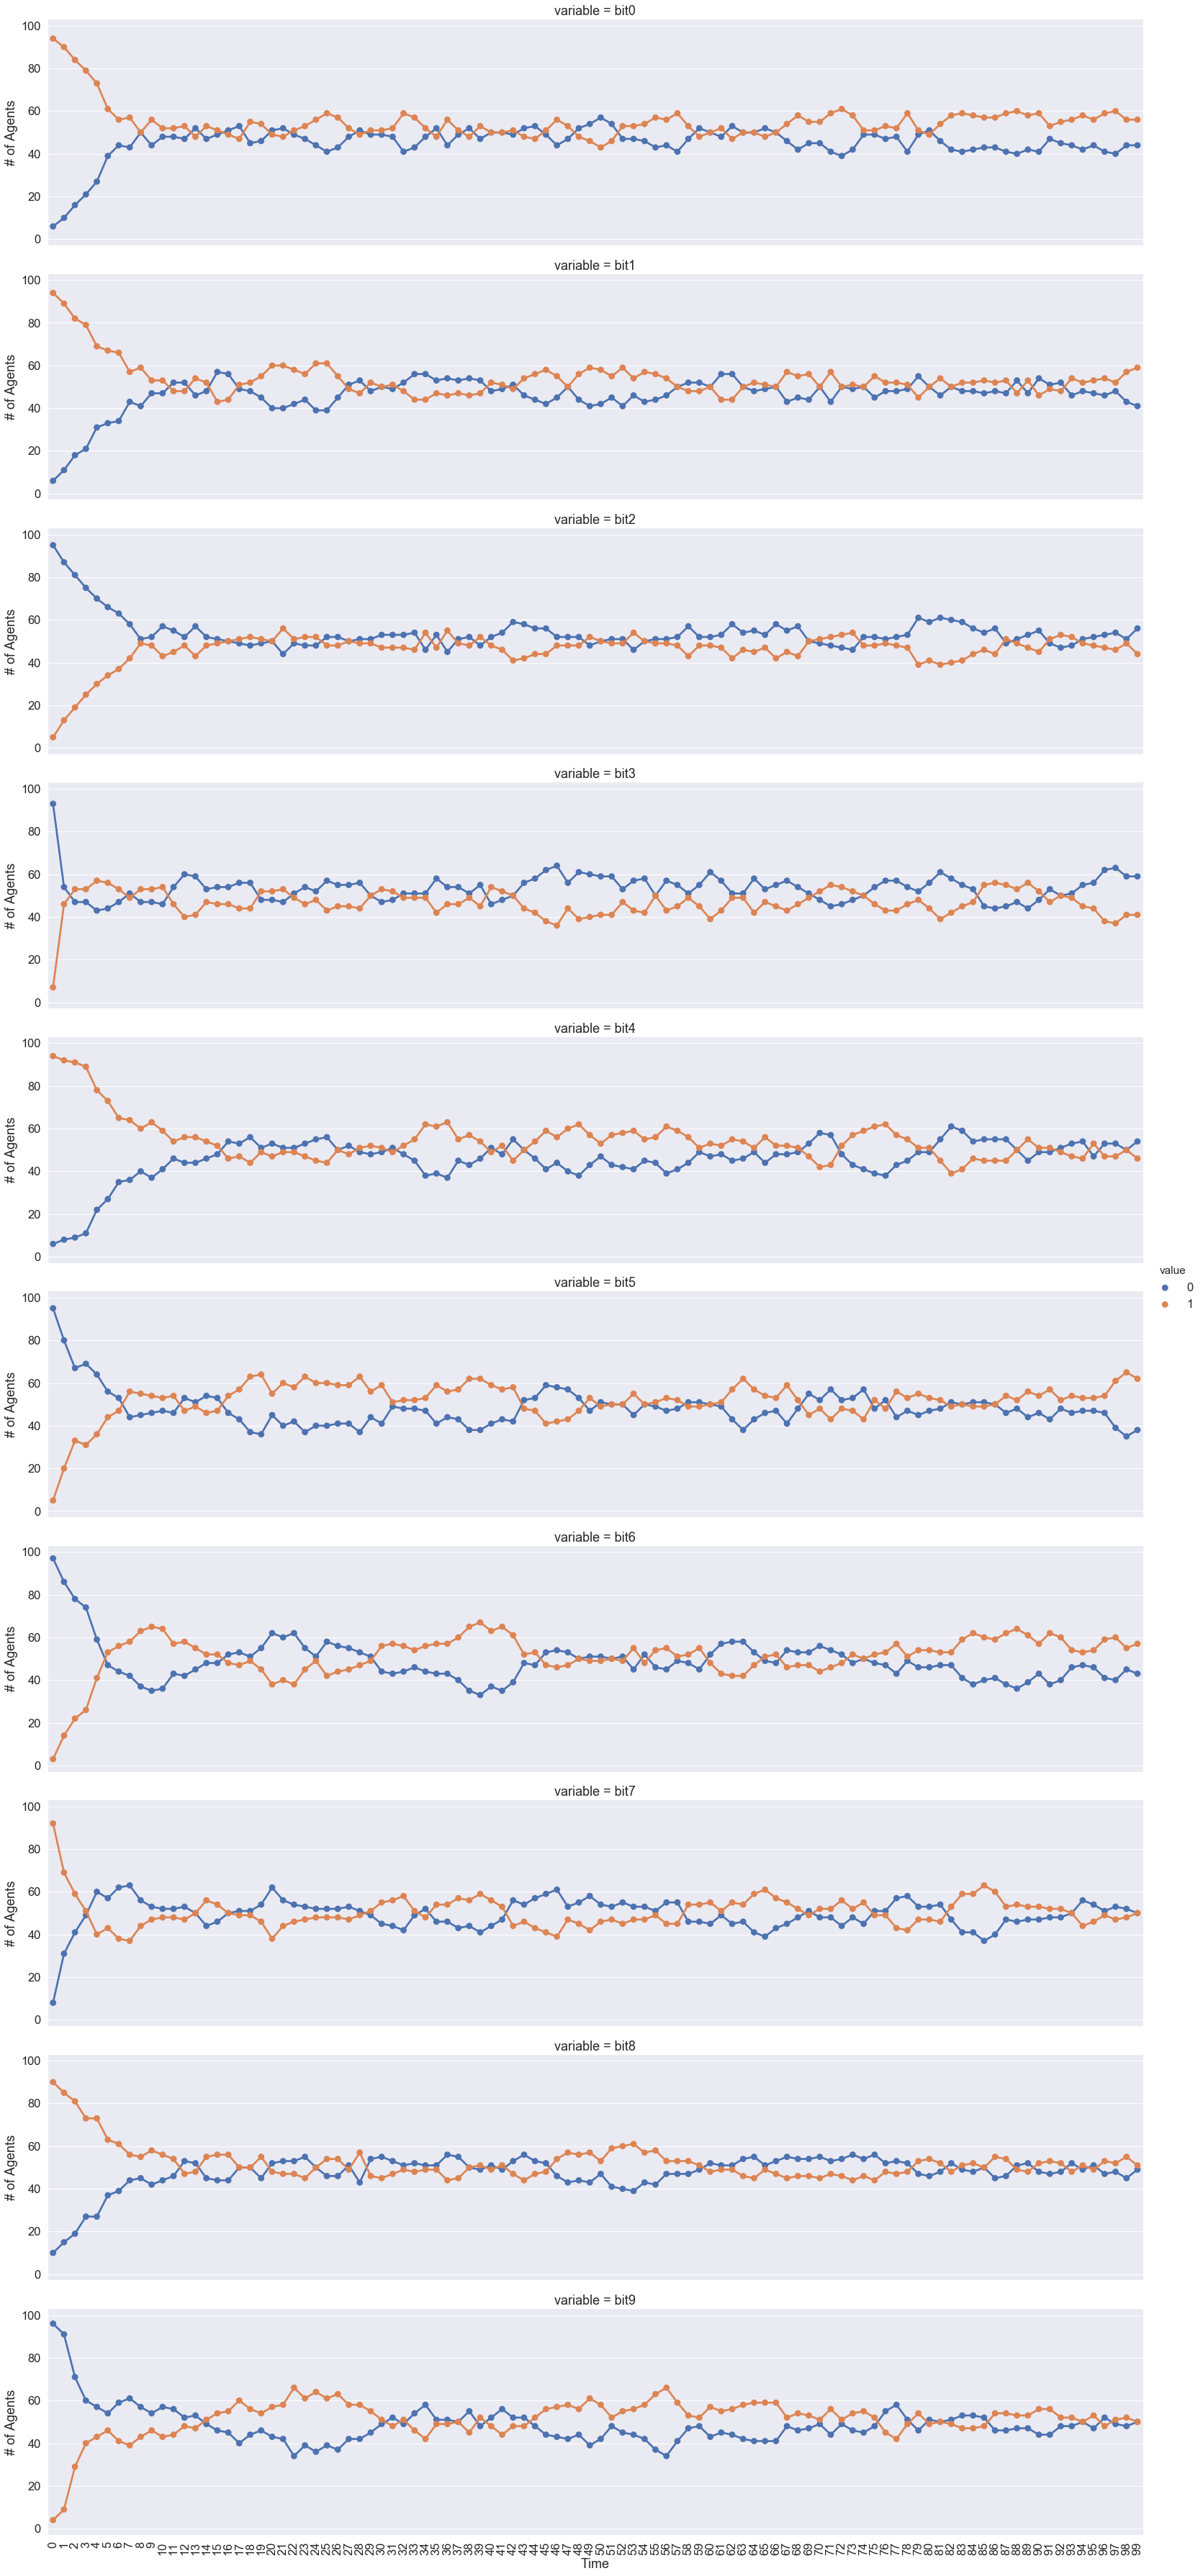

In [10]:
sns.set(style='darkgrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
plot_bit_changes(raw_df, '0')

Compared to alpha of value 0 when increased to 0.5 there is some little more frequent state transition.

Top 10 highest frequent state transitions are: 


,Current_Knowledge_State,Next_Knowledge_State,Count
1497,115,115.0,121.0
1477,115,51.0,63.0
3891,370,370.0,55.0
1120,99,99.0,44.0
3962,371,371.0,38.0
1496,115,114.0,32.0
485,51,51.0,31.0
1415,114,115.0,31.0
3894,370,374.0,29.0
496,51,115.0,26.0


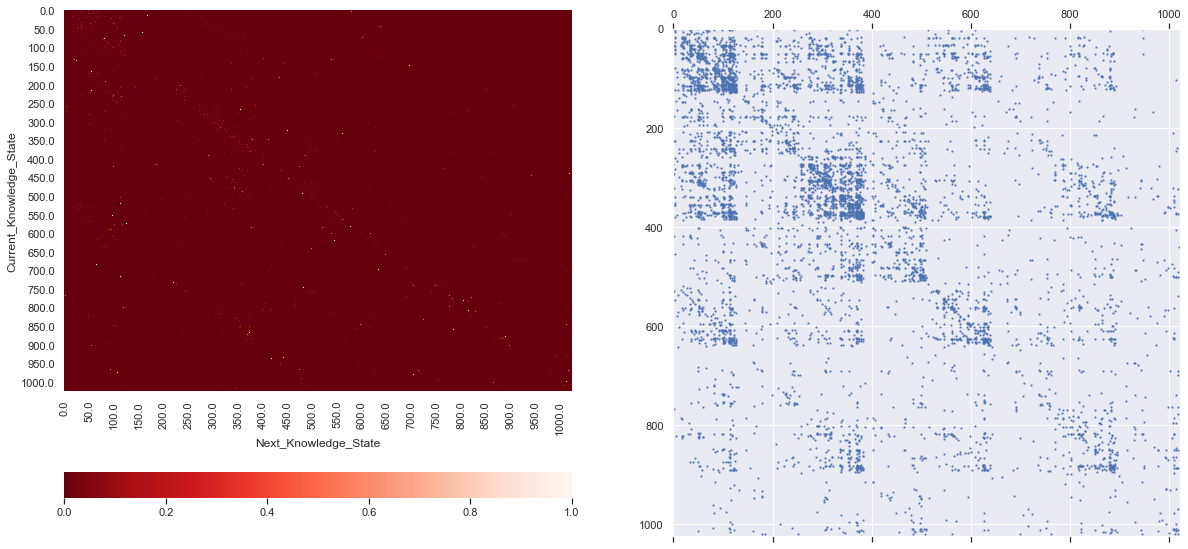

In [11]:
sns.set(rc={'figure.figsize':(20,10)})
plot_heatmap(tmp_df, '0.5')

Bit Changes for Alpha value 0.5


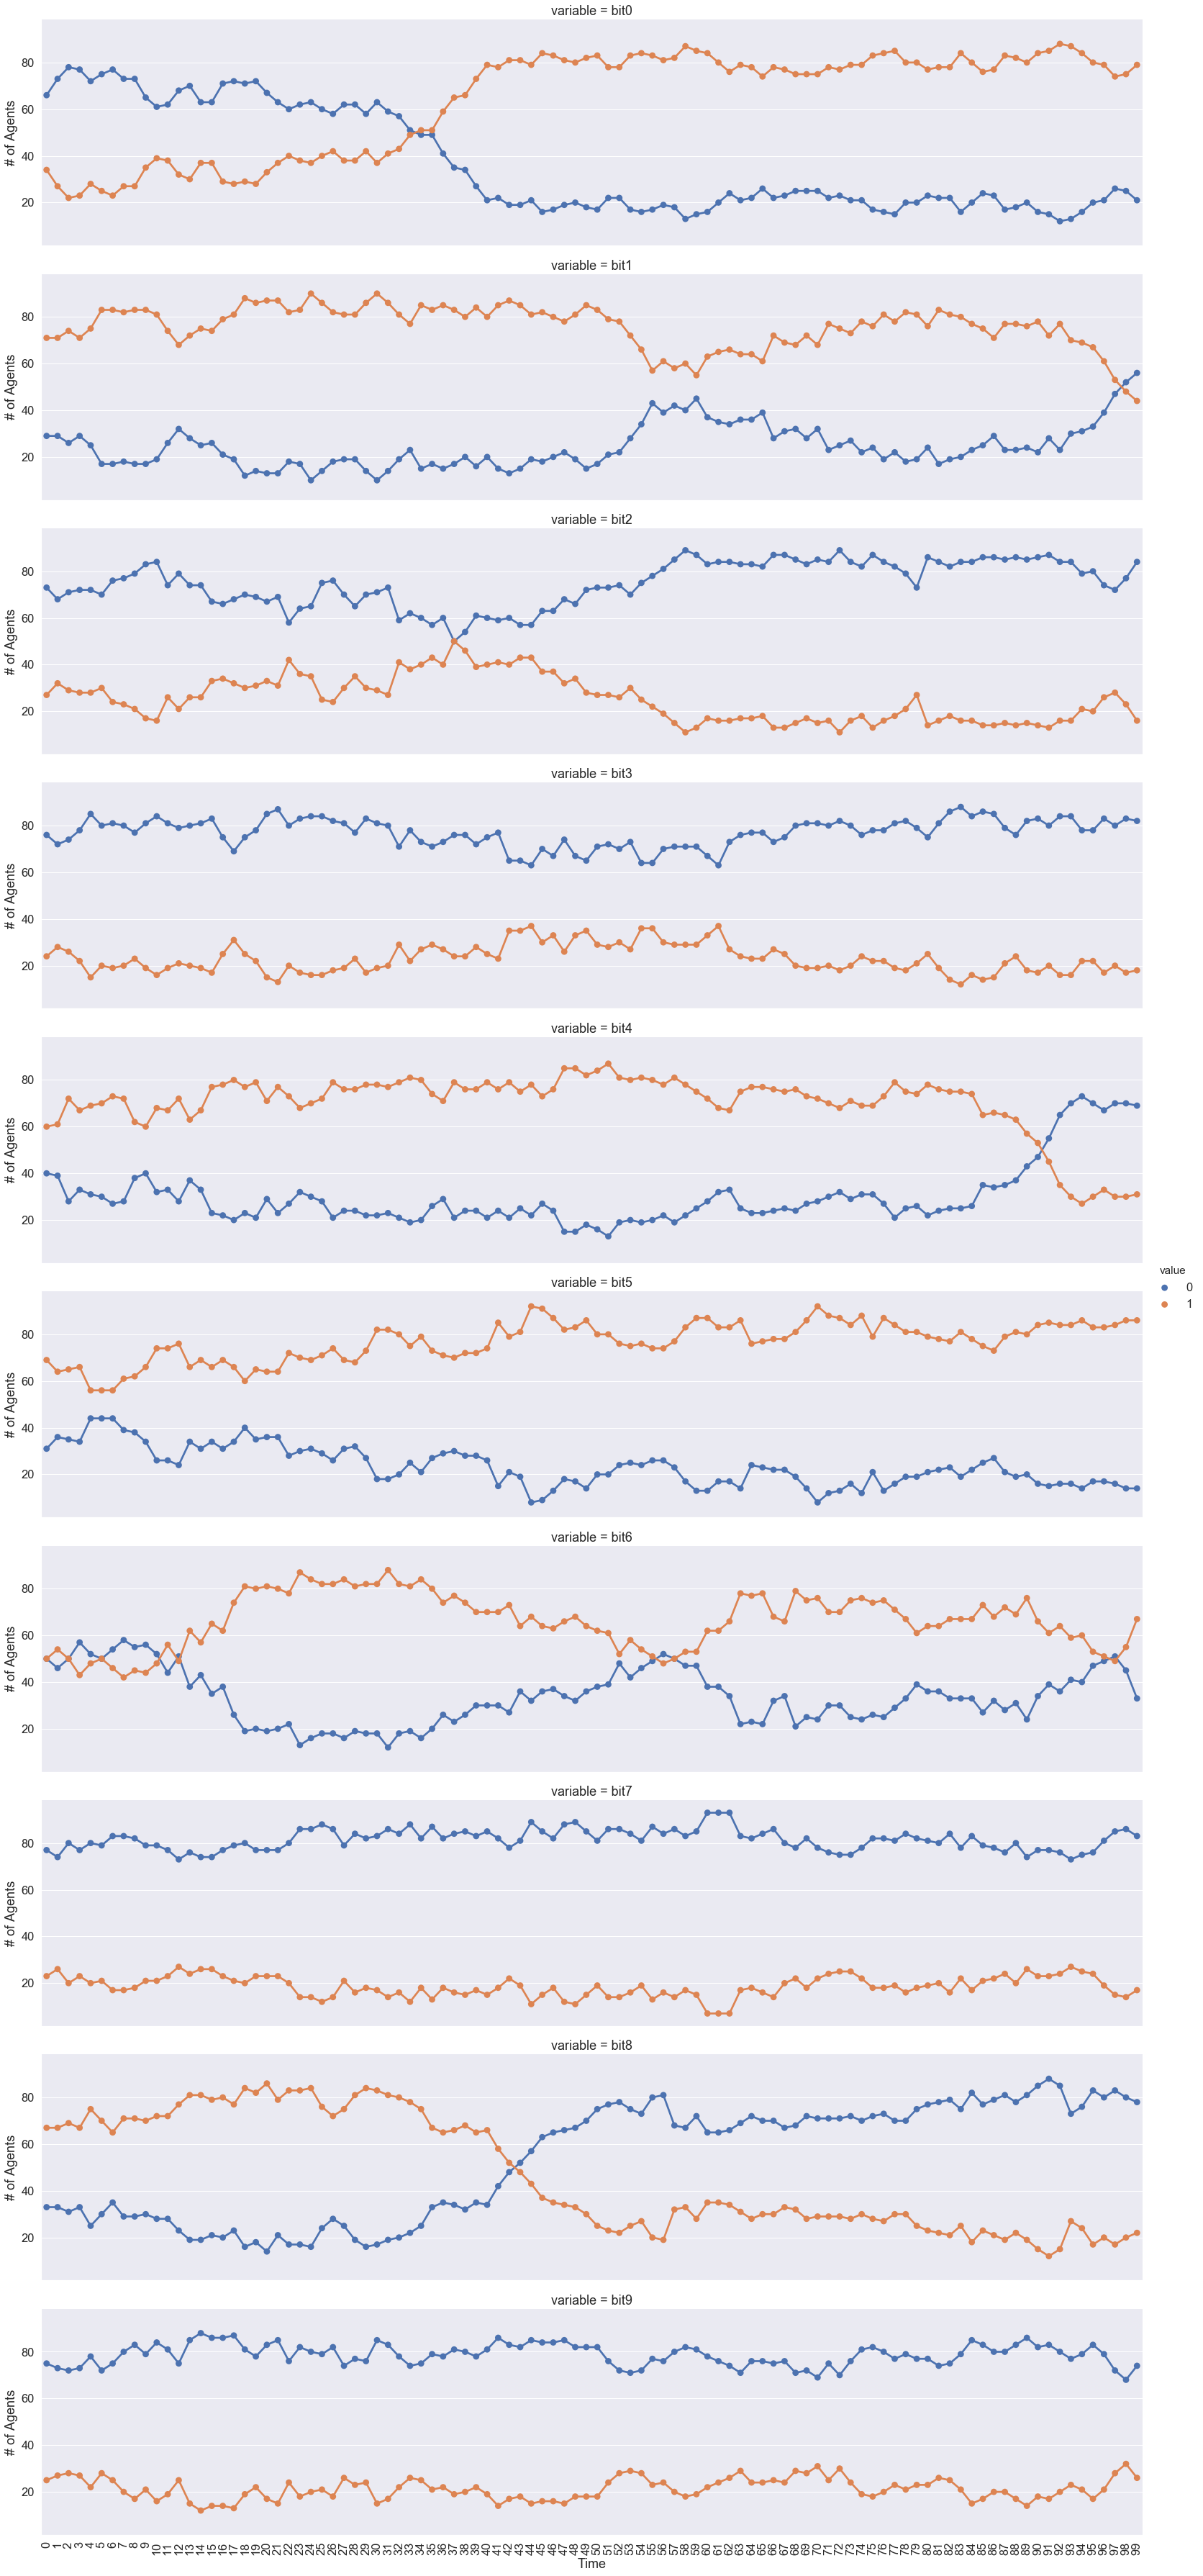

In [12]:
sns.set(style='darkgrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
plot_bit_changes(raw_df, '0.5')

Increasing alpha to 0.9 it seems that states are more stable and change does not have frequently. It can be seen from both heatmap as well as bit changes. From bit changes we can see number of agents gap remains consistent and few agent flip bits.

Top 10 highest frequent state transitions are: 


,Current_Knowledge_State,Next_Knowledge_State,Count
498,99,99.0,3079.0
496,99,97.0,255.0
389,97,99.0,213.0
497,99,98.0,192.0
439,98,99.0,172.0
96,35,99.0,145.0
479,99,35.0,143.0
1256,355,99.0,132.0
617,103,99.0,116.0
540,99,355.0,114.0


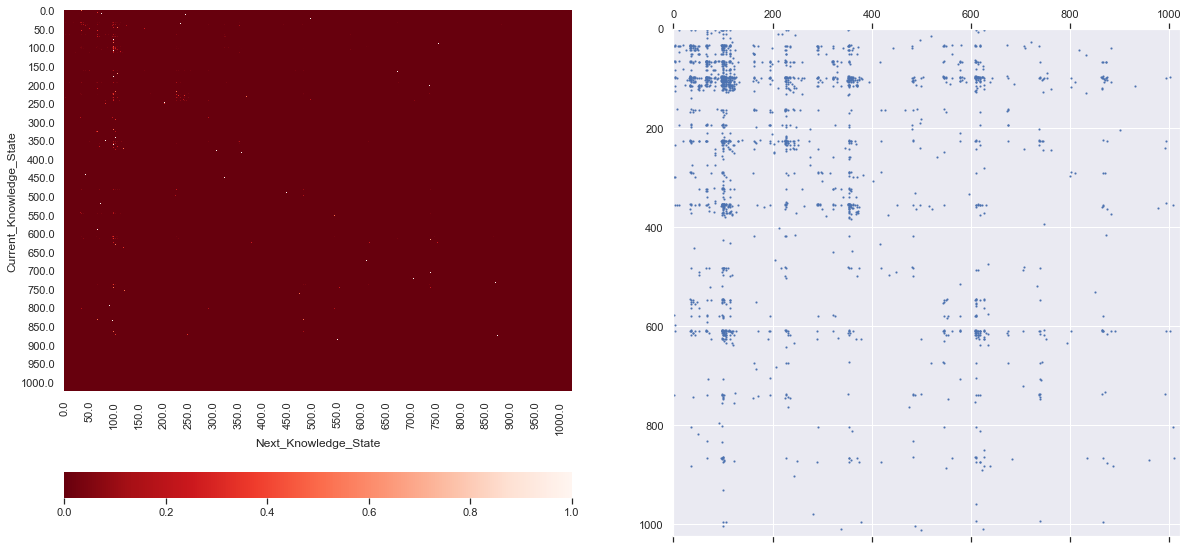

In [13]:
sns.set(rc={'figure.figsize':(20,10)})
plot_heatmap(tmp_df, '0.9')

Bit Changes for Alpha value 0.9
0001100011


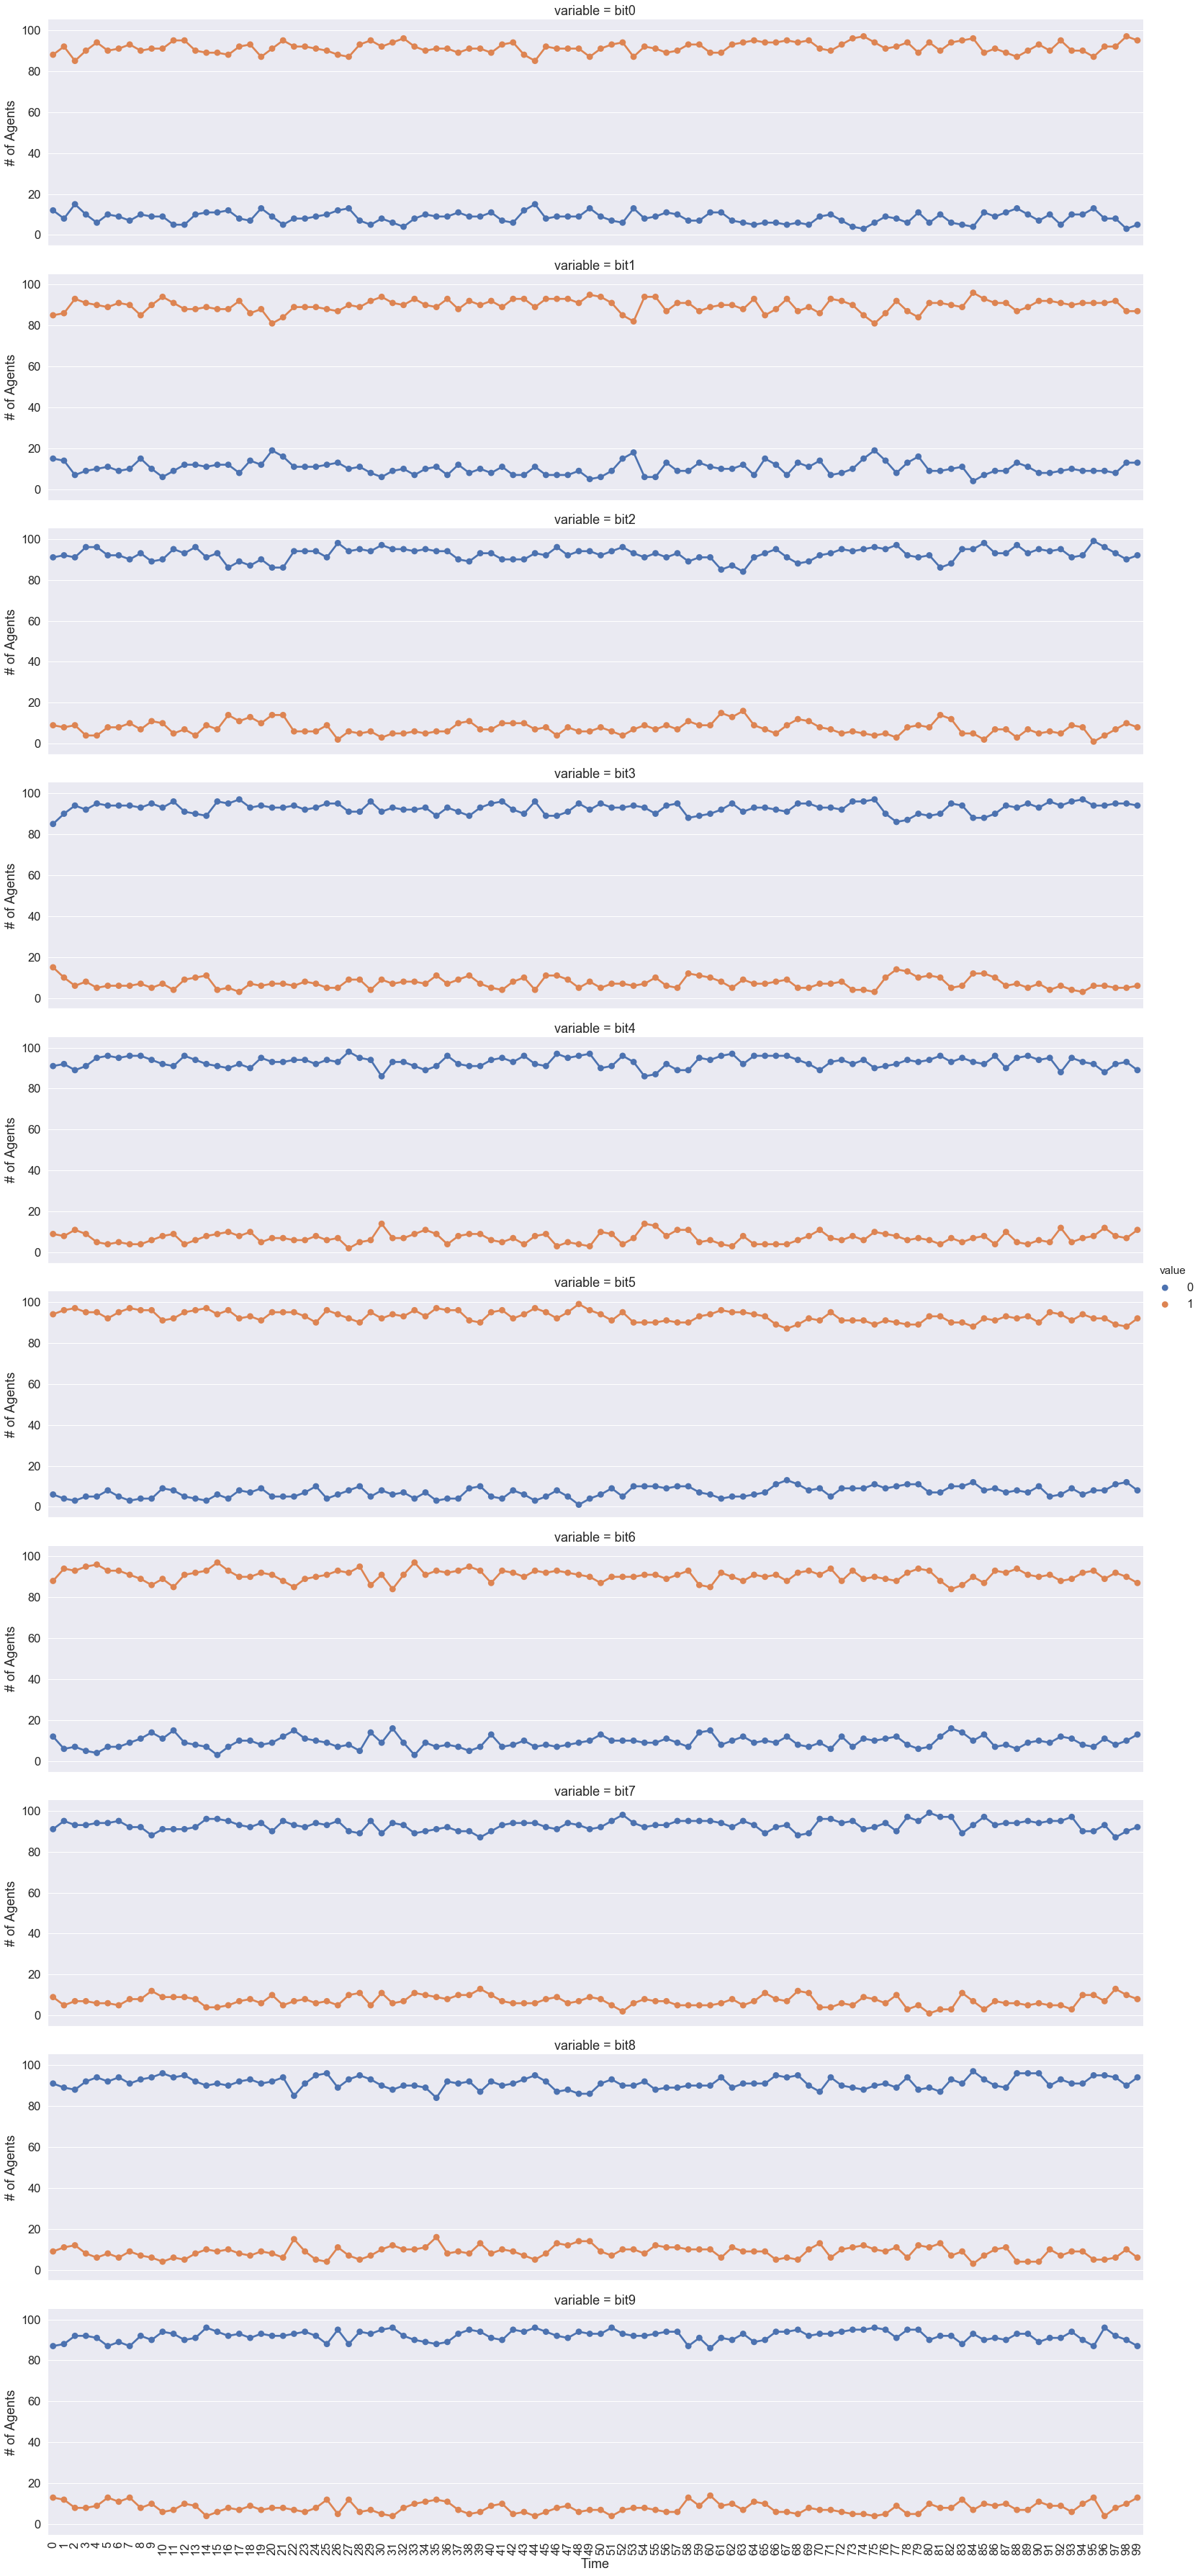

In [14]:
sns.set(style='darkgrid', rc={'figure.figsize':(11,8)}, font_scale=1.5)
plot_bit_changes(raw_df, '0.9')
print(format(99, '010b'))